<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter06/Class_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Activation Maps

Feature maps are intermediate activations that come after a convolution operation. Typically, the shape of these activation maps is `n-channels x height x width`. If we take the mean of all these activations, they show the hotspots of all the classes in the image. But if we are interested in locations that are only important for a particular class (say, `cat`), we need to figure out only those feature maps among `n-channels` that are responsible for that class. For the convolution layer that generated these feature maps, we can compute its gradients with respect to the `cat` class. Note that only those channels that are responsible for predicting `cat` will have a high gradient. This means that we can use the gradient information to give weightage to each of `n-channels` and obtain an activation map exclusively for `cat`.

Now that we understand the high-level strategy of how to generate CAMs, let's put it into practice step by step:
1. Decide for which class you want to calculate the CAM and for which convolutional layer in the neural network you want to compute the CAM.
2. Calculate the activations arising from any convolutional layer – let's say the feature shape at a random convolution layer is 512 x 7 x 7.
3. Fetch the gradient values arising from this layer with respect to the class of interest. The output gradient shape is 256 x 512 x 3 x 3 (which is the shape of the convolutional tensor – that is, `in-channels x out-channels x kernel-size x kernel-size`).
4. Compute the mean of the gradients within each output channel. The output shape is 512.
5. Calculate the weighted activation map – which is the multiplication of the 512 gradient means by the 512 activation channels. The output shape is `512 x 7 x 7`.
6. Compute the mean (across 512 channels) of the weighted activation map to fetch an output of the shape 7 x 7.
7. Resize (upscale) the weighted activation map outputs to fetch an image of a size that is of the same size as the input. This is done so that we have an activation map that resembles the original image.
8. Overlay the weighted activation map onto the input image.

The following diagram from the paper [Grad-CAM: Gradient-weighted Class Activation Mapping](https://arxiv.org/abs/1610.02391) pictorially describes the preceding steps:

![GradCAM](CVPTch06-GradCAM.png)

The key to the entire process lies in step 5. We consider two aspects of the step:
- If a certain pixel is important, then the CNN will have a large activation at those pixels.
- If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large.  

On multiplying these two, we indeed end up with a map of importance across all the pixels

In [1]:
import os
dataset_path = os.path.expanduser('/home/guy/datasets/malaria_cell/cell_images/')
if not os.path.exists(dataset_path):
#     !pip install -U -q torch_snippets
#     !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
#     !unzip -qq cell_images.zip
#     !rm cell_images.zip
    print(f'could not find dataset in {dataset_path}')
from torch_snippets import *

In [2]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [3]:
from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05), 
                  contrast=(0.95,1.05), 
                  saturation=(0.95,1.05), 
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [4]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [5]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [6]:
all_files = Glob(dataset_path+'cell_images/*/*.png')
len(all_files)

27558

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# all_files = Glob(dataset_path+'cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

2022-03-17 09:59:46.035 | INFO     | __main__:__init__:6 - 20668
2022-03-17 09:59:46.036 | INFO     | __main__:__init__:6 - 6890


In [8]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [9]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [14]:
from torchsummary import summary
model = MalariaClassifier().to(device)
summary(model, (3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Sequential: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Dropout: 3-1                 [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-2                  [-1, 64, 128, 128]        1,792
|    |    └─ReLU: 3-3                    [-1, 64, 128, 128]        --
|    |    └─BatchNorm2d: 3-4             [-1, 64, 128, 128]        128
|    |    └─MaxPool2d: 3-5               [-1, 64, 64, 64]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Dropout: 3-6                 [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 64, 64]          36,928
|    |    └─ReLU: 3-8                    [-1, 64, 64, 64]          --
|    |    └─BatchNorm2d: 3-9             [-1, 64, 64, 64]          128
|    |    └─MaxPool2d: 3-10              [-1, 64, 32, 32]          --
|    └

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2]                   --
|    └─Sequential: 2-1                   [-1, 64, 64, 64]          --
|    |    └─Dropout: 3-1                 [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-2                  [-1, 64, 128, 128]        1,792
|    |    └─ReLU: 3-3                    [-1, 64, 128, 128]        --
|    |    └─BatchNorm2d: 3-4             [-1, 64, 128, 128]        128
|    |    └─MaxPool2d: 3-5               [-1, 64, 64, 64]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Dropout: 3-6                 [-1, 64, 64, 64]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 64, 64]          36,928
|    |    └─ReLU: 3-8                    [-1, 64, 64, 64]          --
|    |    └─BatchNorm2d: 3-9             [-1, 64, 64, 64]          128
|    |    └─MaxPool2d: 3-10              [-1, 64, 32, 32]          --
|    └

In [15]:
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 0.268	trn_acc: 0.888	val_loss: 0.158	val_acc: 0.950	(85.22s - 85.22s remaining)
EPOCH: 2.000	trn_loss: 0.175	trn_acc: 0.943	val_loss: 0.151	val_acc: 0.956	(166.25s - 0.00s remaining)


In [27]:
# form a sub-network that includes all layers up to the last conv2d (see layer 3-27 above) with shape [-1, 64, 4, 4]
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))
im2fmap.children

In [30]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [31]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


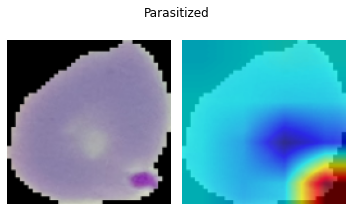

torch.Size([1, 64, 4, 4])


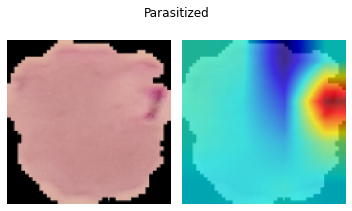

torch.Size([1, 64, 4, 4])


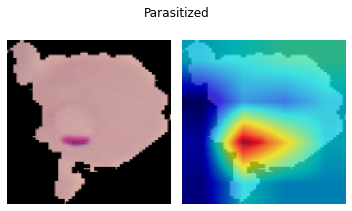

torch.Size([1, 64, 4, 4])


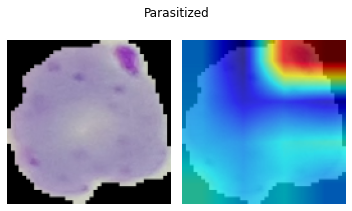

torch.Size([1, 64, 4, 4])


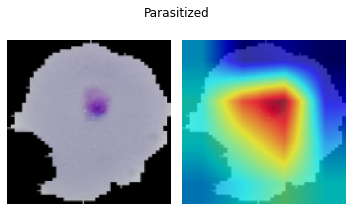

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


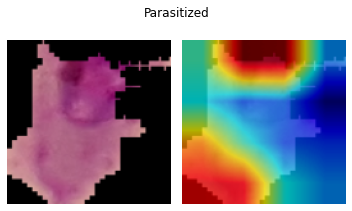

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


In [32]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

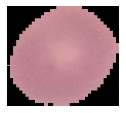

In [54]:
show(z[12])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


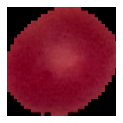

In [55]:
show(x[12])